<h1 style="color:blue; font-size:36px;">Projet Machine Learning 4A</h1>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time


### <span style="color:blue">**Introduction** </span>

**Le jeu de données "Energy" couvre la période de 2000 à 2020 et fournit des informations détaillées sur la consommation énergétique et la géographie de 176 pays. Avec 3649 observations et 21 variables, telles que l'accès à l'électricité, la part des énergies renouvelables et les émissions de CO2, notre objectif est de prédire la variable "Value-co2-emissions" en utilisant les autres variables disponibles. Dans cette étude, nous chercherons à évaluer les performances des modèles d'apprentissage automatique tels que la régression linéaire, les machines à vecteurs de support (SVM), l'arbre de décision (CART) et Random Forest pour atteindre cet objectif**

### <span style="color:blue">**I. Prétraitement des données** </span>

#### <span style="color:blue">**I.1 Suppression des NAN** </span>

In [11]:
energy=pd.read_csv('global-data-on-sustainable-energy.csv')

**En utilisant la statistique "count", nous remarquons des variations dans le nombre d'observations pour chaque variable, ce qui suggère la présence de données manquantes.**

In [12]:
(energy.isna().sum()/energy.shape[0]*100).sort_values(ascending=False)

Renewables (% equivalent primary energy)                            58.563990
Financial flows to developing countries (US $)                      57.248561
Renewable-electricity-generating-capacity-per-capita                25.513839
Value_co2_emissions_kt_by_country                                   11.729241
gdp_growth                                                           8.687312
gdp_per_capita                                                       7.728145
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          5.672787
Renewable energy share in the total final energy consumption (%)     5.316525
Access to clean fuels for cooking                                    4.631406
Electricity from nuclear (TWh)                                       3.453001
Low-carbon electricity (% electricity)                               1.151000
Electricity from renewables (TWh)                                    0.575500
Electricity from fossil fuels (TWh)                             

**Nous allons procéder à l'élimination des variables "Renewables", "Financial flows to developing countries" et "Renewable-electricity-generating-capacity-per-capita" en raison de leur taux élevé de données manquantes, situé entre 25 % et 60 %. Ensuite, nous filtrerons tous les individus présentant des valeurs non disponibles (NaN) pour les variables restantes. Cette étape nous permettra de conserver 2868 individus avec 18 variables.**

In [13]:
energy.drop(['Renewable-electricity-generating-capacity-per-capita','Financial flows to developing countries (US $)','Renewables (% equivalent primary energy)'],axis=1,inplace=True)

In [14]:
energy.dropna(axis=0,inplace=True)
energy.shape

(2868, 18)

In [15]:
energy.iloc[:,14]=energy.iloc[:,14].str.replace(',','') #on remplace les virgule de la colonne Density par un espace
energy.iloc[:, 14] = pd.to_numeric(energy.iloc[:, 14], errors='coerce')

#### <span style="color:blue">**I.2 Conversion des variables 'Year' et 'Entity'** </span>

In [16]:
energy['Year'] = energy['Year'].astype('category')
energy.rename(columns={energy.columns[14]: 'Density'}, inplace=True)#renommer la colonne Density pour faciliter l'accés à la variable
energy['Density']= pd.to_numeric(energy['Density'], errors='coerce')


In [17]:
# Regrouper les émissions de CO2 par pays
co2_by_country = energy.groupby('Entity')['Value_co2_emissions_kt_by_country'].sum().reset_index()

# Trier les pays par ordre décroissant en fonction des émissions de CO2
co2_by_country_sorted = co2_by_country.sort_values(by='Value_co2_emissions_kt_by_country', ascending=False)

# Afficher les résultats
print(co2_by_country_sorted)

                    Entity  Value_co2_emissions_kt_by_country
27                   China                       1.527328e+08
142          United States                       1.065908e+08
62                   India                       3.267958e+07
68                   Japan                       2.367469e+07
50                 Germany                       1.547289e+07
..                     ...                                ...
35                Djibouti                       2.520000e+03
145                Vanuatu                       2.460000e+03
114  Sao Tome and Principe                       1.860000e+03
71                Kiribati                       1.190000e+03
92                   Nauru                       5.300000e+02

[148 rows x 2 columns]


##### Les 5 pays les plus émetteurs de CO2 sont: La chine, les etats unis,l'inde, le japon et L'Allmagne

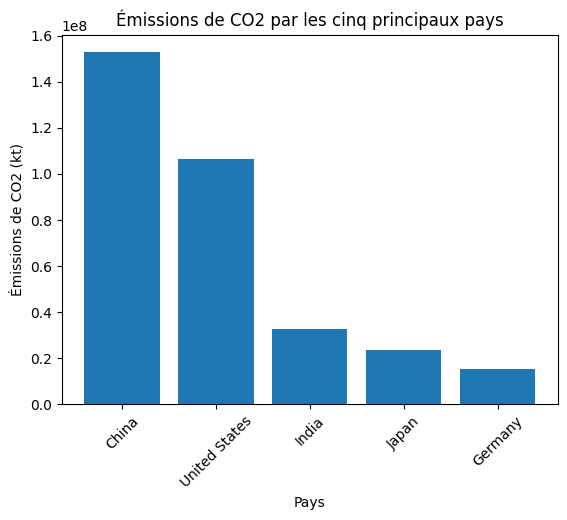

In [18]:
# Sélectionner les cinq principaux pays
top_5_countries = co2_by_country_sorted.head(5)

# Tracer l'histogramme
plt.bar(top_5_countries['Entity'], top_5_countries['Value_co2_emissions_kt_by_country'])
plt.xlabel('Pays')
plt.ylabel('Émissions de CO2 (kt)')
plt.title('Émissions de CO2 par les cinq principaux pays')
plt.xticks(rotation=45)
plt.show()

**On supprime également la variable Electricity from fossil fuels (TWh). Cette variable étant très corrélée avec la variable à prédire ,  on l'enlève d'après la consigne.**

In [19]:
energy.drop(['Electricity from fossil fuels (TWh)'],axis=1,inplace=True)

### <span style="color:blue">**II. Analyse unidimentionnelle** </span>

#### <span style="color:blue">*II.1 Variables qualitatives* </span>

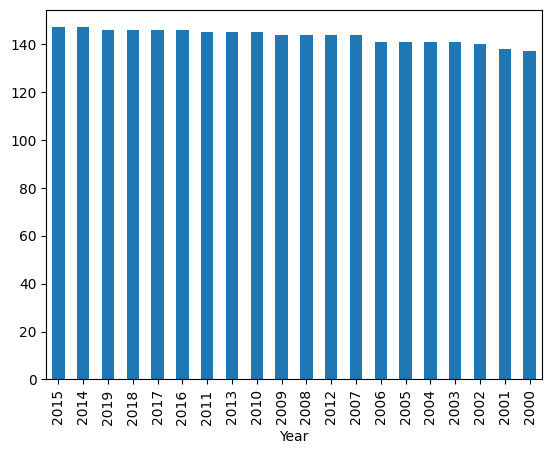

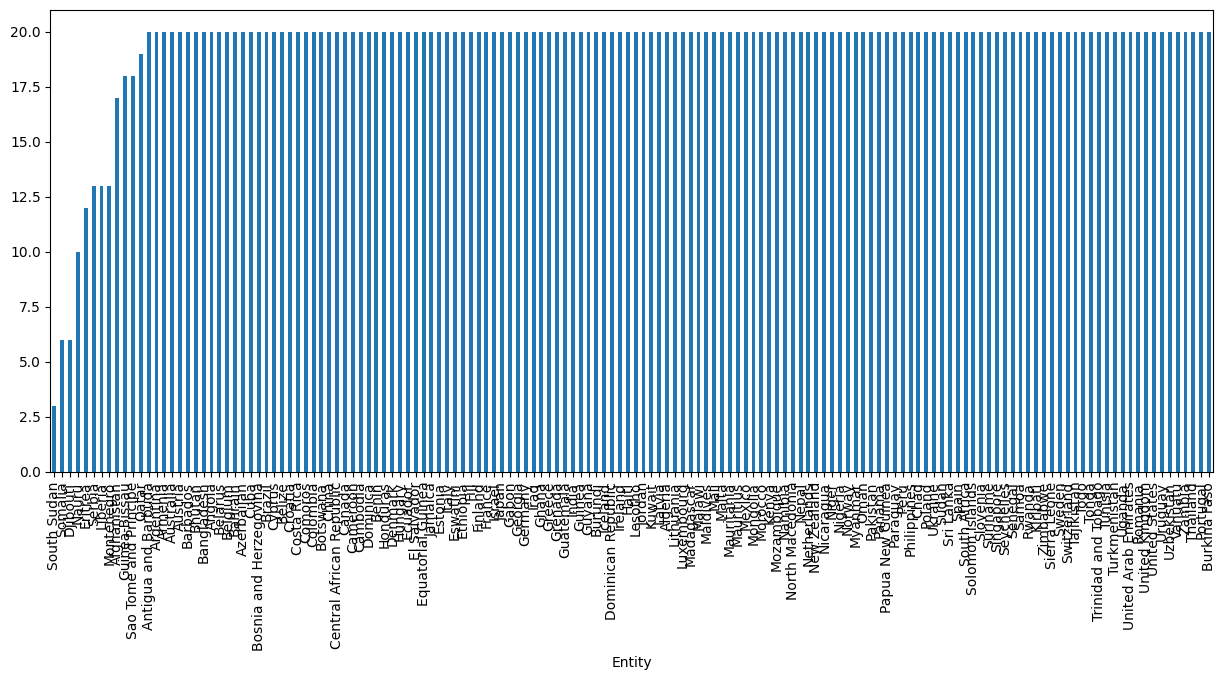

In [20]:
energy['Year'].value_counts().plot.bar()
plt.figure(figsize=(15,6))

energy['Entity'].value_counts().sort_values(ascending=True).plot.bar()
plt.tick_params(axis='x', rotation=90)

**Nous observons des disparités dans le nombre d'observations pour chaque année. Les années les plus anciennes présentent moins d'observations que les plus récentes, ce qui peut indiquer une amélioration dans la collecte des données au fil du temps. De plus, il est important de noter que nous n'avons pas le même nombre d'observations pour chaque pays. Certains pays, comme le South Sudan, ont significativement moins d'observations par rapport aux autres.**

#### <span style="color:blue">*II.2 Variables quantitatives* </span>

In [21]:
energyQuant=energy.iloc[:,2:] #On extrait que les variables quantitatives

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Access to electricity (% of population)'),
  Text(1, 0, 'Access to clean fuels for cooking'),
  Text(2, 0, 'Renewable energy share in the total final energy consumption (%)'),
  Text(3, 0, 'Electricity from nuclear (TWh)'),
  Text(4, 0, 'Electricity from renewables (TWh)'),
  Text(5, 0, 'Low-carbon electricity (% electricity)'),
  Text(6, 0, 'Primary energy consumption per capita (kWh/person)'),
  Text(7, 0, 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'),
  Text(8, 0, 'Value_co2_emissions_kt_by_country'),
  Text(9, 0, 'gdp_growth'),
  Text(10, 0, 'gdp_per_capita'),
  Text(11, 0, 'Density'),
  Text(12, 0, 'Land Area(Km2)'),
  Text(13, 0, 'Latitude'),
  Text(14, 0, 'Longitude')])

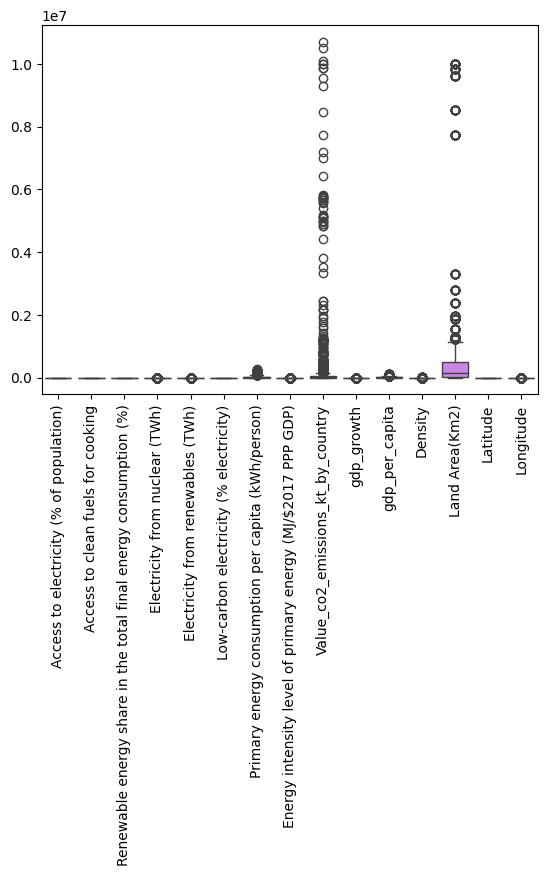

In [22]:
sns.boxplot(energyQuant)
plt.xticks(rotation=90)

**Nous notons que nos variables présentent non seulement des unités de mesure variées, mais aussi des échelles différentes. Certaines variables ont une importance relative plus élevée que d'autres. Afin d'homogénéiser nos données on va les centrer et les reduire.**

**Nous allons maintenant déterminer les variables qui présentent le plus d'outliers**

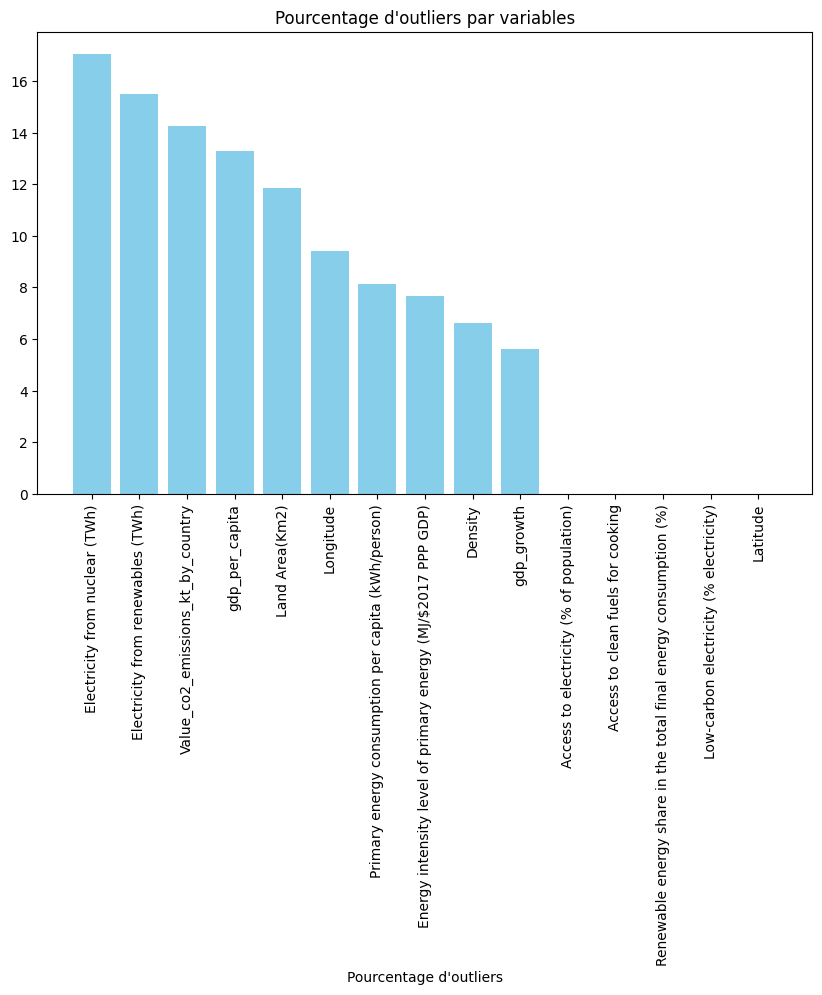

In [23]:

def percent_outliers(data): #renvoie
    percent_outliers_list = []
    for i in range(data.shape[1]): 
            q1 = np.percentile(data.iloc[:, i], 25)
            q3 = np.percentile(data.iloc[:, i], 75)
            iqr = q3 - q1
            bornes_inf = q1 - 1.5 * iqr
            bornes_sup = q3 + 1.5 * iqr
            outliers = data.iloc[:, i][(data.iloc[:, i] < bornes_inf) | (data.iloc[:, i] > bornes_sup)]
            percent_outliers = 100 * len(outliers) / len(data.iloc[:, i])
            percent_outliers_list.append((data.columns[i], percent_outliers))
    return percent_outliers_list

pourcentages_outliers = percent_outliers(energyQuant)

# Tri de la liste par ordre croissant en fonction du pourcentage d'outliers
pourcentages_outliers_tries = sorted(pourcentages_outliers, key=lambda x: x[1],reverse=True)


# Séparation des colonnes et des pourcentages
colonnes = [colonne for colonne, _ in pourcentages_outliers_tries]
pourcentages = [pourcentage for _, pourcentage in pourcentages_outliers_tries]

# Tracé du graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(colonnes, pourcentages, color='skyblue')
plt.xlabel("Pourcentage d'outliers")
plt.title("Pourcentage d'outliers par variables")
plt.xticks(rotation=90)
plt.show()
        
    






**On remarque après analyse beacoup d'outliers au niveau des variables 'Electricity from fossil fuels', 'Electricity from nuclear' et 'Electricity from renewables'. Il contiennent plus 15% de valeurs aberrantes. Il est plausible que dans certains pays par rapport aux autres, ces sources d'énergie soient beaucoup plus abondantes et largement utilisées, ce qui peut entraîner des fluctuations  dans les données.**

**Nous allons maintenant observer la distribution de chaque variable en construisant un histogramme pour chacune d'entre elles.**.

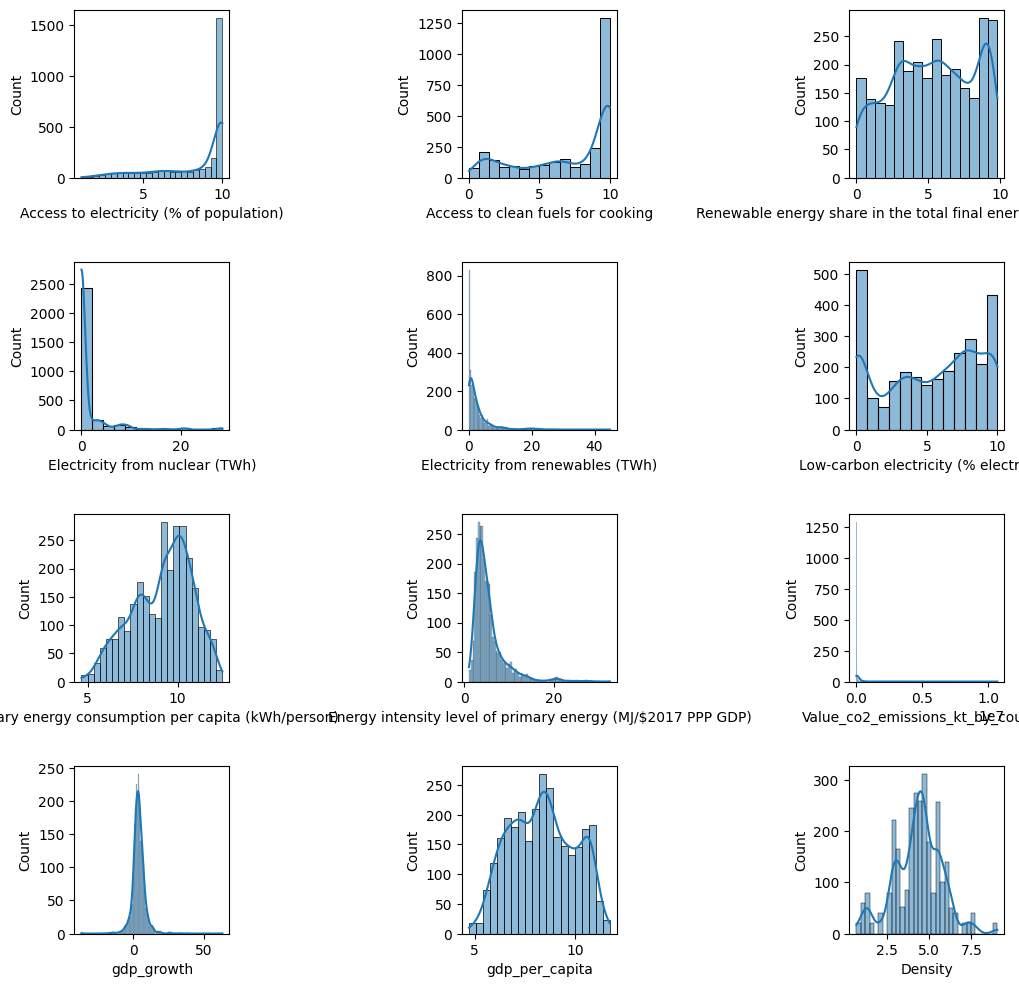

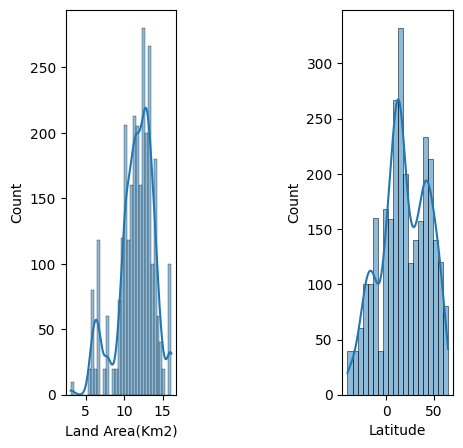

In [26]:
fig,ax=plt.subplots(4,3,figsize=(12, 12))
plt.subplots_adjust(wspace=1.5,hspace=0.5)
k=0
for i in range(4):
    for j in range(3):
        sns.histplot(energyQuant.iloc[:, k], kde=True, ax=ax[i, j])
        k+=1

plt.show()
fig,ax=plt.subplots(1,2,figsize=(5, 5))
plt.subplots_adjust(wspace=1.5,hspace=0.5)
for j in range(2):
    sns.histplot(energyQuant.iloc[:, k], kde=True, ax=ax[j])
    k+=1

**Nous remarquons que de nombreuses variables ne suivent pas une distribution gaussienne. Pour remédier à cela, nous allons appliquer des transformations logarithmiques ou racine carrée.**

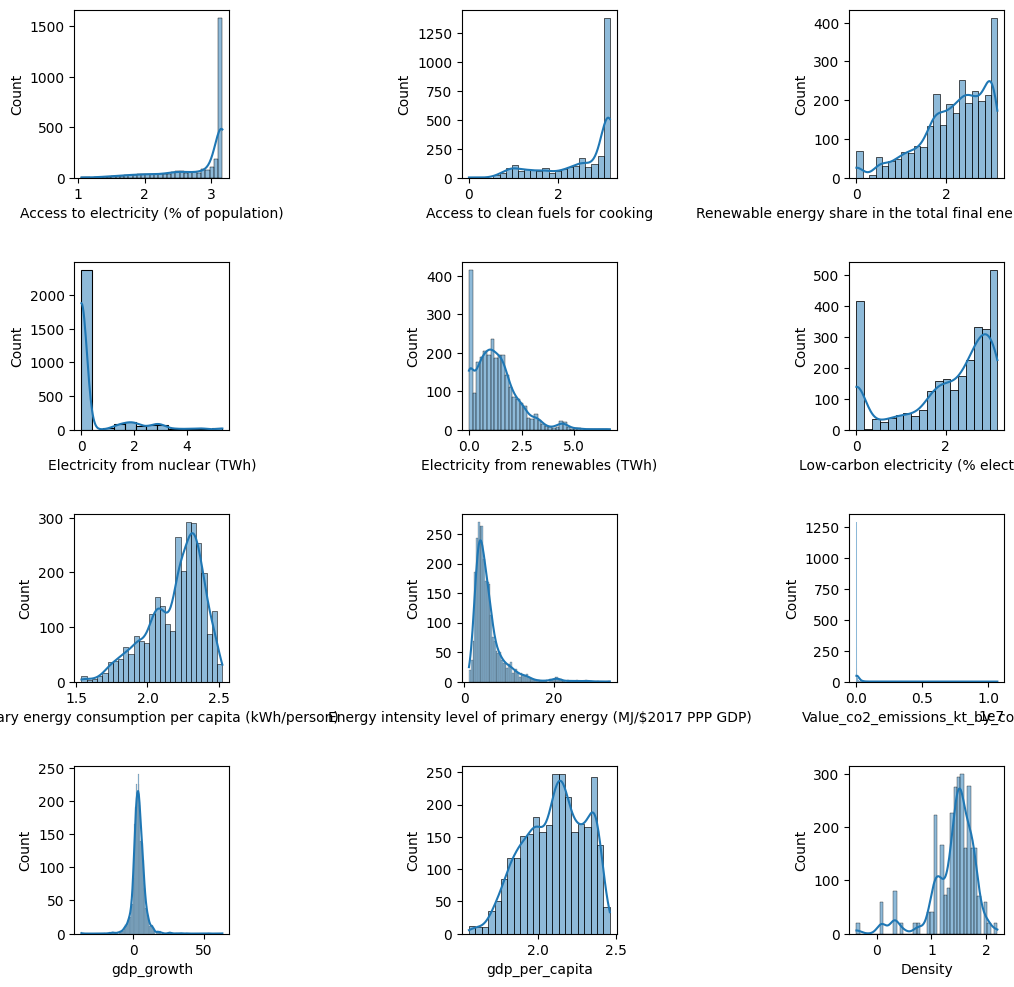

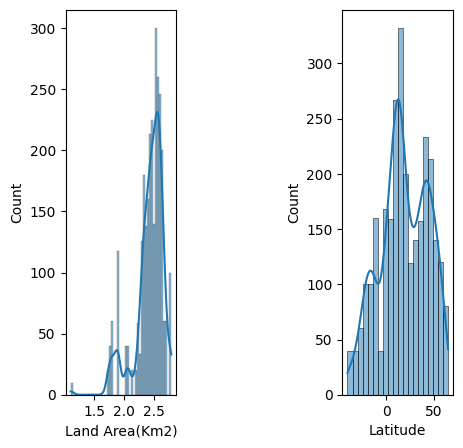

In [27]:
# Prendre la racine carrée des colonnes spécifiques
columns_sqrt = ["Access to electricity (% of population)",
                "Access to clean fuels for cooking",
                "Renewable energy share in the total final energy consumption (%)",
                "Electricity from nuclear (TWh)",
                "Electricity from renewables (TWh)",
                "Low-carbon electricity (% electricity)"]
energy[columns_sqrt] = np.sqrt(energy[columns_sqrt])

# Prendre le logarithme des colonnes spécifiques
columns_log = ["Primary energy consumption per capita (kWh/person)",
               "gdp_per_capita",
               "Density",
               "Land Area(Km2)"]
energy[columns_log] = np.log(energy[columns_log])

energyQuant=energy.iloc[:,2:]

fig,ax=plt.subplots(4,3,figsize=(12, 12))
plt.subplots_adjust(wspace=1.5,hspace=0.5)
k=0
for i in range(4):
    for j in range(3):
        sns.histplot(energyQuant.iloc[:, k], kde=True, ax=ax[i, j])
        k+=1

plt.show()
fig,ax=plt.subplots(1,2,figsize=(5, 5))
plt.subplots_adjust(wspace=1.5,hspace=0.5)
for j in range(2):
    sns.histplot(energyQuant.iloc[:, k], kde=True, ax=ax[j])
    k+=1

### <span style="color:blue">**II. Analyse multidimentionnelle** </span>

<Axes: >

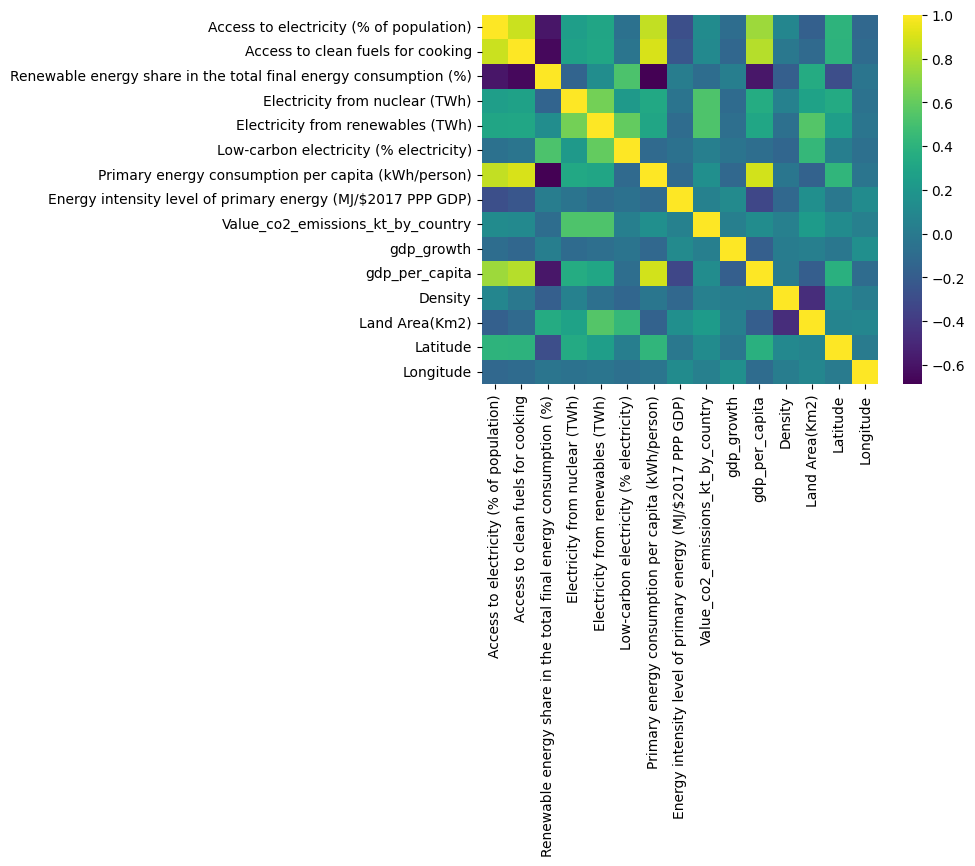

In [29]:
sns.heatmap(energyQuant.corr(), cmap='viridis')


**Selon le graphique de corrélation , on observe que la variable à prédire, la quantité d'émissions de CO2 par pays (Value_co2_emissions_kt_by_country), présente une corrélation plus significative avec la production d'électricité à partir de sources renouvelables, et dans une moindre mesure avec la production d'électricité d'origine nucléaire. Cependant, elle affiche une corrélation négative avec la proportion d'énergie renouvelable dans la consommation totale d'électricité.**
**La corrélation observée peut sembler contre-intuitive. Cependant, elle peut être expliquée par le fait que les pays plus riches ont souvent une capacité plus importante à investir dans le nucléaire et les énergies renouvelables. Ainsi, une plus grande production d'électricité à partir de ces sources pourrait être associée à des niveaux d'émissions de CO2 plus élevés, car des niveaux de richesse plus importante.**
**Par ailleurs, la corrélation négative entre les émissions de CO2 et la part d'énergie renouvelable dans la consommation d'électricité souligne l'importance des énergies propres pour réduire ces émissions.**

#### <span style="color:blue">b. Analyse en composantes principales</span>

**Nous allons réaliser une Analyse en Composantes Principales (ACP) sur l'ensemble de données, à l'exception de la variable que nous cherchons à prédire. L'objectif de cette analyse est de simplifier la complexité de nos données en réduisant leurs dimensions, tout en préservant au maximum leur structure et leurs informations essentielles.**

In [30]:
Value_co2_emissions_kt_by_country=np.log(energy['Value_co2_emissions_kt_by_country'])
energy.drop(['Value_co2_emissions_kt_by_country'],axis=1,inplace=True)
energyQuant.drop(['Value_co2_emissions_kt_by_country'],axis=1,inplace=True)
Value_co2_emissions_kt_by_country.reset_index(drop=True,inplace=True)
Value_co2_emissions_kt_by_country.index

RangeIndex(start=0, stop=2868, step=1)

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler=StandardScaler()
scaler.fit(energyQuant)
energyQuant1=scaler.transform(energyQuant)
pca=PCA()
energyQuant1_pca=pca.fit(energyQuant1).transform(energyQuant1)


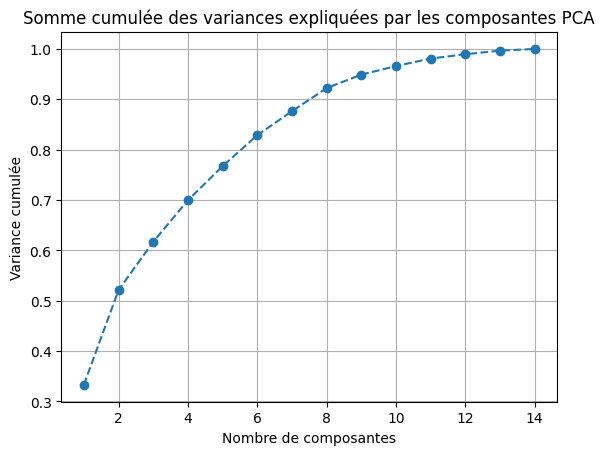

In [55]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Tracer la somme cumulée des variances
plt.plot(range(1,15),cumulative_variance,marker='o',linestyle="--")
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Somme cumulée des variances expliquées par les composantes PCA')
plt.grid(True)
plt.show()

**Nous constatons que 6 dimensions suffisent pour expliquer 80% de la variance dans nos données.**.

**On trace le graphe des individus colorié en fonction du taux d'émission de C02 , puis par le continent auquel les individus (pays) appartiennent**

In [56]:
import country_converter as coco
Continents= coco.convert(names=energy['Entity'], to='continent')


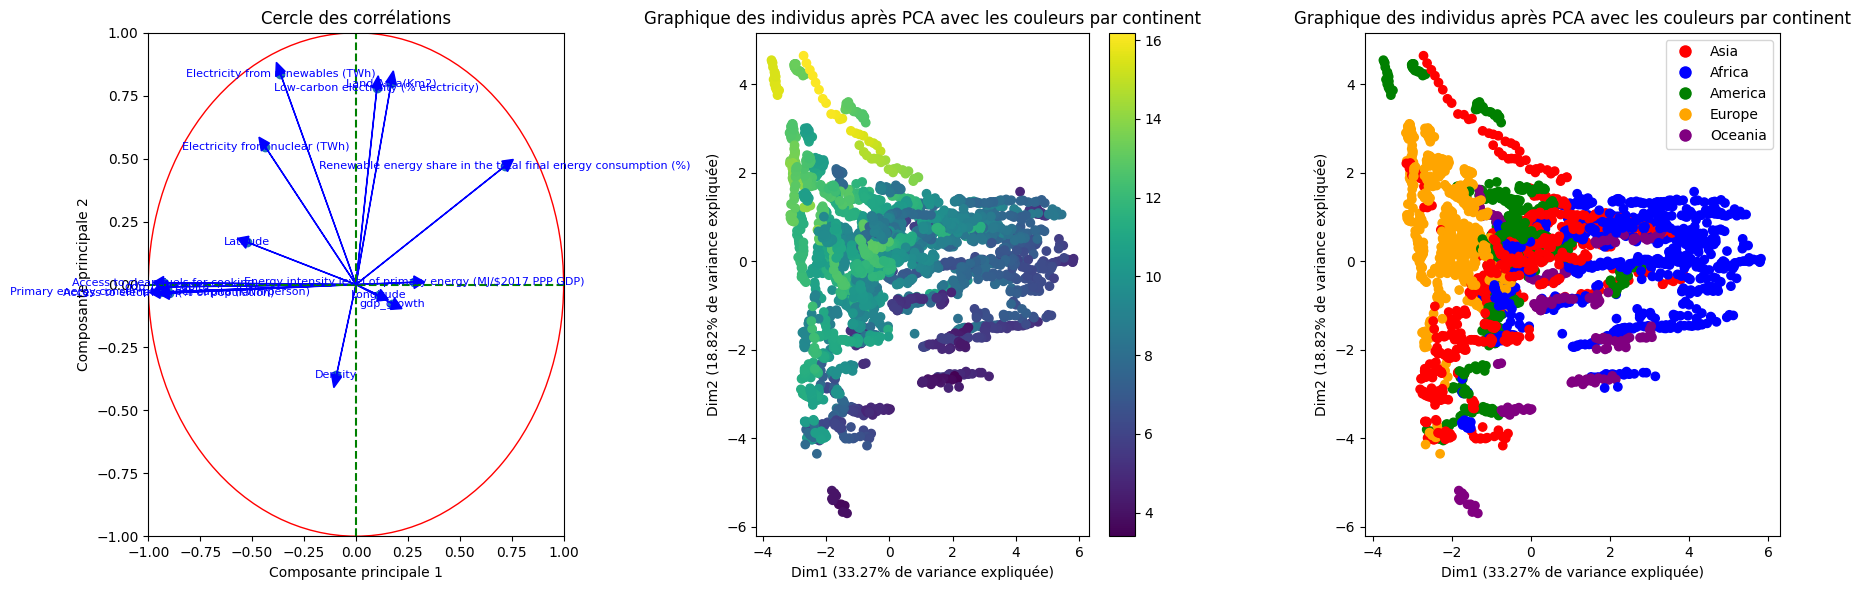

In [62]:
coord1 = pca.components_[0] * np.sqrt(pca.explained_variance_[0])
coord2 = (-1)*pca.components_[1] * np.sqrt(pca.explained_variance_[1])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Premier graphique : Cercle des corrélations
axes[0].scatter(coord1, coord2)
for i, j, nom in zip(coord1, coord2, energyQuant.columns):
    axes[0].text(i, j, nom, fontsize=8, ha='center', va='center', color='blue')
    axes[0].arrow(0, 0, i, j, color='blue', head_width=0.05, head_length=0.05)
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(-1, 1)
axes[0].axhline(0, linestyle='dashed', color='green')
axes[0].axvline(0, linestyle='dashed', color='green')
cercle = plt.Circle((0, 0), radius=1, color='red', fill=False)
axes[0].add_patch(cercle)
axes[0].set_xlabel('Composante principale 1')
axes[0].set_ylabel('Composante principale 2')
axes[0].set_title('Cercle des corrélations')

# Deuxième graphique : Graphique des individus après PCA
sc=axes[1].scatter(energyQuant1_pca[:, 0], (-1)*energyQuant1_pca[:, 1], c=Value_co2_emissions_kt_by_country)
axes[1].set_xlabel(f'Dim1 ({pca.explained_variance_ratio_[0]*100:.2f}% de variance expliquée)')
axes[1].set_ylabel(f'Dim2 ({pca.explained_variance_ratio_[1]*100:.2f}% de variance expliquée)')
axes[1].set_title('Graphique des individus après PCA avec les couleurs par continent')
plt.colorbar(sc, ax=axes[1])

# Troisième graphique : Graphique des individus après PCA avec les couleurs par continent
continent_colors = {'Asia': 'red', 'Africa': 'blue', 'America': 'green', 'Europe': 'orange', 'Oceania': 'purple'}
colors = [continent_colors[continent] for continent in Continents]
axes[2].scatter(energyQuant1_pca[:, 0], (-1)*energyQuant1_pca[:, 1], c=[continent_colors[continent] for continent in Continents], label='Continents')
axes[2].set_xlabel(f'Dim1 ({pca.explained_variance_ratio_[0]*100:.2f}% de variance expliquée)')
axes[2].set_ylabel(f'Dim2 ({pca.explained_variance_ratio_[1]*100:.2f}% de variance expliquée)')
axes[2].set_title('Graphique des individus après PCA avec les couleurs par continent')

axes[2].legend(np.unique(Continents))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=continent, 
                             markerfacecolor=color, markersize=10) 
                  for continent, color in continent_colors.items()]
axes[2].legend(handles=legend_handles)

plt.tight_layout()
plt.show()


**Il est remarquable que les pays les plus pollueurs sont fortement corrélés avec la dimension 2, et également fortement corrélés négativement avec la dimension 1. Les émissions de CO2 sont ainsi négativement corrélées avec la dimension 1 et positivement avec la dimension 2.**

**Dans le graphique des individus, la plupart des pays européens se trouvent principalement du côté négatif de la dimension 1, tandis que les pays africains sont positivement corrélés. Quant aux pays asiatiques et américains, bien que des pays comme les États-Unis, la Chine et le Japon se positionnent aux extrémités négatives en raison de leurs fortes émissions de CO2, la plupart des autres pays de ces continents se situent du côté positif. Cette observation corrobore l'idée que la pollution est liée à la richesse, comme suggéré par la matrice de corrélation. Le PIB par habitant est d'ailleurs fortement corrélé négativement à la dimension. Ainsi1il y'ant un lien significatif entrlate dimensio1 n et la richessdesdu pays.**

**Quant à la dimension 2, elle est positivement corrélée avec la taille du pays (Land Area), la quantité d'électricité renouvelable, nucléaire et bas carbone. Le graphique des individus révèle également une corrélation positive entre la quantité de CO2 émise et la dimension 2, suggérant ainsi que cette dimension pourrait être associée à l'accès à l'électricité.**

### <span style="color:blue">**III. Modélisations** </span>

In [75]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score


In [63]:
energy.reset_index(drop=True,inplace=True)
energyQuant.reset_index(drop=True,inplace=True)

**Les variables Entiy et Year possédant trop de modalités on va passer à un modèle simplifié ou les pays sont regroupés par continent et les années par période quadriennale pour faciliter la modélisation linéaire et son interprètation.**

In [71]:
energy2=energy.copy()
energy2['Year']=energy2['Year'].astype(int)

bins = [2000, 2004, 2008, 2012, 2016, 2020]

# Étiquettes pour les intervalles
labels = ['2000-2004', '2004-2008', '2008-2012', '2012-2016', '2016-2020']

# Ajouter la nouvelle variable qualitative au DataFrame
energy2['Periode'] = pd.cut(energy2['Year'], bins=bins, labels=labels, right=False)

# Afficher les premières lignes pour vérifier
energy2.drop(columns=['Year'],inplace=True)

energy2['Continent']= coco.convert(names=energy2['Entity'], to='continent')
energy2.drop(columns=['Entity'],inplace=True)

energy2.head()




,Access to electricity (% of population),Access to clean fuels for cooking,Renewable energy share in the total final energy consumption (%),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),gdp_growth,gdp_per_capita,Density,Land Area(Km2),Latitude,Longitude,Periode,Continent
0,1.959356,1.755622,2.460640,0.0,0.890913,2.861233,1.693401,1.40,8.832278,1.658346,1.409607,2.59437,33.93911,67.709953,2000-2004,Asia
1,2.116458,1.817007,2.579014,0.0,0.865062,2.816434,1.671333,1.20,1.414118,1.677782,1.409607,2.59437,33.93911,67.709953,2004-2008,Asia
2,2.244758,1.868917,2.412603,0.0,0.876421,2.822229,1.710134,1.41,11.229715,1.702758,1.409607,2.59437,33.93911,67.709953,2004-2008,Asia
3,2.354240,1.929134,2.376368,0.0,0.894427,2.954440,1.743691,1.50,5.357403,1.718281,1.409607,2.59437,33.93911,67.709953,2004-2008,Asia
4,2.450357,1.977757,2.316182,0.0,0.930605,2.980811,1.769870,1.53,13.826320,1.772449,1.409607,2.59437,33.93911,67.709953,2004-2008,Asia


In [73]:
dataDum=pd.get_dummies(energy2[['Periode','Continent']]) #Transformation des variables qualitatives en indicatrice

energy2= pd.concat([dataDum, energyQuant], axis=1) 
energy2.head()

,Periode_2000-2004,Periode_2004-2008,Periode_2008-2012,Periode_2012-2016,Periode_2016-2020,Continent_Africa,Continent_America,Continent_Asia,Continent_Europe,Continent_Oceania,...,Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),gdp_growth,gdp_per_capita,Density,Land Area(Km2),Latitude,Longitude
0,True,False,False,False,False,False,False,True,False,False,...,0.890913,2.861233,1.693401,1.40,8.832278,1.658346,1.409607,2.59437,33.93911,67.709953
1,False,True,False,False,False,False,False,True,False,False,...,0.865062,2.816434,1.671333,1.20,1.414118,1.677782,1.409607,2.59437,33.93911,67.709953
2,False,True,False,False,False,False,False,True,False,False,...,0.876421,2.822229,1.710134,1.41,11.229715,1.702758,1.409607,2.59437,33.93911,67.709953
3,False,True,False,False,False,False,False,True,False,False,...,0.894427,2.954440,1.743691,1.50,5.357403,1.718281,1.409607,2.59437,33.93911,67.709953
4,False,True,False,False,False,False,False,True,False,False,...,0.930605,2.980811,1.769870,1.53,13.826320,1.772449,1.409607,2.59437,33.93911,67.709953


**Nous allons diviser le jeu de données en deux ensembles distincts : un ensemble d'apprentissage et un ensemble de test.**

In [79]:

scaler = StandardScaler()  



XTrain, XTest, YTrain, YTest = train_test_split(energy2, Value_co2_emissions_kt_by_country, test_size=0.2, random_state=111)
scaler.fit(XTrain)
Xr_train = scaler.transform(XTrain)

Xr_test = scaler.transform(XTest)

#### <span style="color:blue">**III.A Regression linéaire** </span>

#### <span style="color:blue">**III.A Régression linéaire sans sélection de variables** </span>

**La régression linéaire va modéliser la relation entre l'émission de CO2 $ Y $ (la variable à prédire) et les autres variables du jeu de données $ X_1, X_2, ..., X_n $ (les variables explicatives). Elle cherche à établir une relation linéaire entre les variables en ajustant les coefficients $ \beta_0, \beta_1, \beta_2, ..., \beta_n $ de manière à minimiser la somme des carrés des écarts entre les valeurs prédites par le modèle et les valeurs réelles observées.**

**La formule de la régression linéaire est la suivante :**

\
**$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n + \varepsilon$**
\

Où :
**- $ Y $ est la variable à prédire,**
**- $ X_1, X_2, ..., X_n $ les variables explicatives,**
**- $ \beta_0 $ est l'ordonnée à l'origine (le biais),**
**- $ \beta_1, \beta_2, ..., \beta_n $ sont les coefficients des variables explicatives,**
**- $ \varepsilon $ est l'erreur résiduelle qui représente la différence entre les valeurs prédites et les valeurs réelles.**


In [107]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import pylab 

Mse_M = {}
Time_M={}
    
start_time = time.time()
regLin = LinearRegression()
regLin.fit(Xr_train, YTrain)
n,k=energy2.shape


# Making predictions on the testing set
y_chap_RL = regLin.predict(Xr_test)

# Calculating mean squared error
RL_mse = mean_squared_error(YTest, y_chap_RL)
RL_R2ajus=1-(n-k-1)*(1-r2_score(YTest,y_chap_RL))/(n-1)
end_time = time.time()
Time=end_time-start_time
print("MSE =", RL_mse)
print("R2aju =",RL_R2ajus)
Mse_M["RegLin"]=RL_mse
Time_M["RegLin"]=Time

MSE = 0.320405936850119
R2aju = 0.9422827914592278


<Figure size 640x480 with 0 Axes>

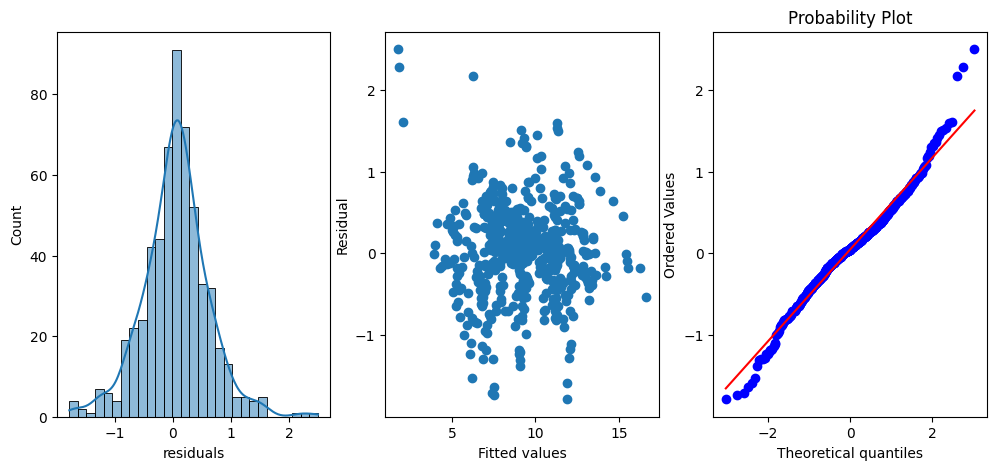

In [108]:
plt.subplots_adjust(wspace=0.5, hspace=1.5)
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
sns.histplot(YTest-y_chap_RL,kde=True)
plt.ylabel('Count')
plt.xlabel('residuals')

plt.subplot(1,3,2)
plt.scatter(y_chap_RL,YTest-y_chap_RL)
plt.xlabel('Fitted values')
plt.ylabel('Residual')
plt.subplot(1,3,3)
stats.probplot(YTest-y_chap_RL, dist="norm", plot=pylab)
pylab.show()
plt.show()

#### <span style="color:blue">**III.A.3 Regression linéaire Lasso** </span>

In [109]:
from sklearn.linear_model import Lasso
# Fitting the Lasso regression model

regLasso = Lasso()
regLasso.fit(Xr_train, YTrain)

# Making predictions on the testing set
y_chap_lasso = regLasso.predict(Xr_test)

# Calculating mean squared error
lasso_mse = mean_squared_error(YTest, y_chap_lasso)
lasso_R2=r2_score(YTest,y_chap_lasso)

print("MSE =", lasso_mse)
print("R2 = ",lasso_R2)
print("Time= ",Time)

MSE = 3.6371204663905607
R2 =  0.33928634435577154
Time=  0.012999773025512695


In [110]:
coef = pd.Series(regLasso.coef_, index = XTrain.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 2 variables et en supprime 22


Text(0, 0.5, 'Residuals')

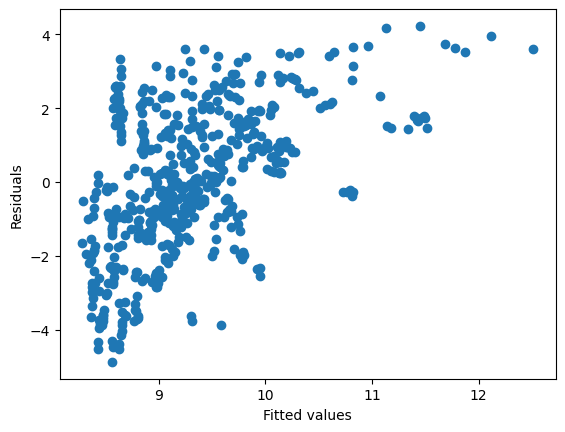

In [111]:
plt.scatter(y_chap_lasso,YTest-y_chap_lasso)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

In [112]:
from sklearn.model_selection import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser

param=[{"alpha":[0,0.05,0.1,0.2,0.3,50,500,1000,1500]}]
regLasso = GridSearchCV(Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, YTrain)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Meilleur R2 = 0.941130, Meilleur paramètre = {'alpha': 0}


C:\Users\maymo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\maymo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\maymo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.747e+02, tolerance: 1.315e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers i

In [113]:
start_time = time.time()

y_chap_lassOpt=regLassOpt.predict(Xr_test)
lassOpt_mse=mean_squared_error(y_chap_lassOpt,YTest)
lassOpt_R2=r2_score(YTest,y_chap_lassOpt)
print("MSE=",lassOpt_mse)
print("R2=",lassOpt_R2)
end_time = time.time()
Time=end_time-start_time
Mse_M["RegLinLasso"]=lasso_mse
Time_M["RegLinLasso"]=Time
#Le modèle est sur paramétré avec 20

MSE= 0.3201158821106665
R2= 0.9418482459809723


<Figure size 640x480 with 0 Axes>

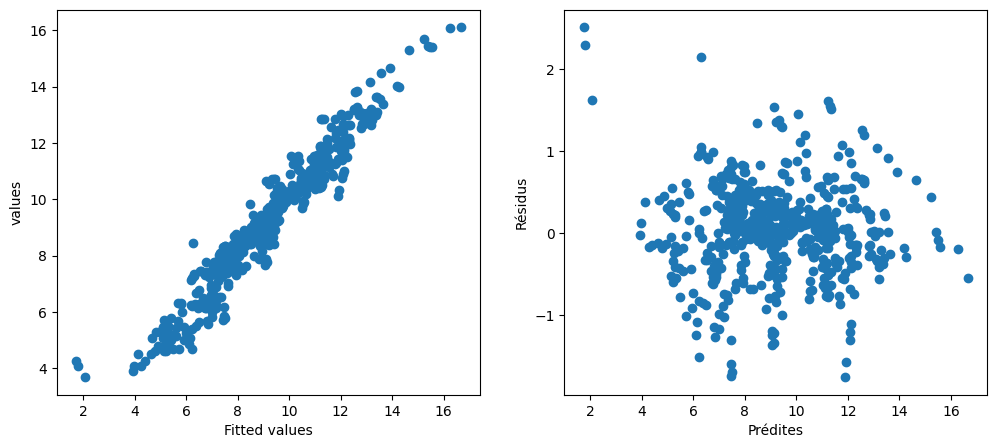

In [114]:
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_chap_lassOpt,YTest,"o")
plt.xlabel("Fitted values")
plt.ylabel("values")

plt.subplot(1,2,2)
plt.plot(y_chap_lassOpt,YTest-y_chap_lassOpt,"o")
plt.xlabel(u"Prédites")
plt.ylabel(u"Résidus")
plt.show()



In [115]:
coef = pd.Series(regLassOpt.best_estimator_.coef_, index = XTrain.columns)
print("LassoOPT conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

LassoOPT conserve 24 variables et en supprime 0


### <span style="color:blue"> **III.B SVM**  </span>

In [116]:
XTr_svm, XT_svm, YTr_svm, YT_svm = train_test_split(energyQuant, Value_co2_emissions_kt_by_country, test_size=0.2, random_state=11)
scaler.fit(XTr_svm)
Xr_train_svm = scaler.transform(XTr_svm)

Xr_test_svm = scaler.transform(XT_svm)



In [117]:
 from sklearn.svm import SVR

param = {'coef0': [2, 3, 4,5,6,7,12,15]}  # Range of C and degree values to try
svm = GridSearchCV(SVR(epsilon=0.1, kernel='poly'), param_grid=param, cv=10, n_jobs=-1)
svmOpt = svm.fit(Xr_train_svm,YTr_svm)

# Best parameters
print("Best score = %f, Best parameters = %s" % (1. - svmOpt.best_score_, svmOpt.best_params_))

Best score = 0.004699, Best parameters = {'coef0': 4}


In [118]:
from sklearn.svm import SVR

param = {'degree': [2, 3, 4,5,6]}  # Range of C and degree values to try
svm = GridSearchCV(SVR(epsilon=0.1,coef0=2, kernel='poly'), param_grid=param, cv=10, n_jobs=-1)
svmOpt = svm.fit(Xr_train_svm, YTr_svm)

# Best parameters
print("Best score = %f, Best parameters = %s" % (1. - svmOpt.best_score_, svmOpt.best_params_))

Best score = 0.004829, Best parameters = {'degree': 3}


In [119]:

#param= {'C': [0,5,10,15,100,200],}
param = {"C":[0.4,0.5,0.6,0.8,1,1.4,10,15]} 
svm= GridSearchCV(SVR(epsilon=0.1,kernel='poly',coef0=2,gamma=0.06),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xr_train_svm, YTr_svm)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))


Meilleur score = 0.004254, Meilleur paramètre = {'C': 10}


In [120]:
svm=SVR(kernel='poly', degree=3, gamma=0.06, coef0=2,  C=10, epsilon=0.2)

Time 1.3917129039764404
MSE= 11.314015085115193


<Figure size 640x480 with 0 Axes>

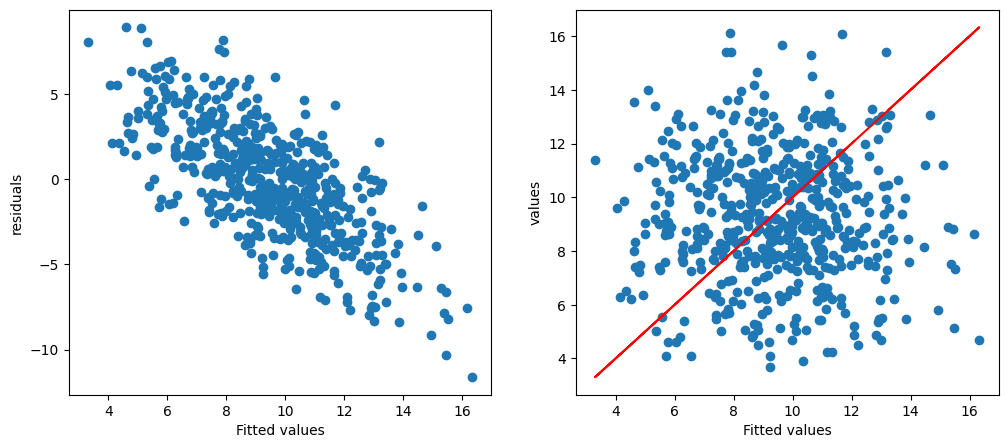

In [121]:
start=time.time()
svmOpt=svm.fit(Xr_train_svm, YTr_svm)
y_chap_svm = svmOpt.predict(Xr_test_svm)
svm_mse=mean_squared_error(y_chap_svm,YTest)
end=time.time()
Time=end-start
Mse_M["SVM"]=svm_mse
Time_M["SVM"]=Time
print("Time",Time)
print("MSE=",svm_mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap_svm,YTest-y_chap_svm)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap_svm,YTest)
plt.plot(y_chap_svm,y_chap_svm,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

### <span style="color:blue"> **III.C Cart**  </span>

In [122]:
 from sklearn.tree import DecisionTreeRegressor
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,18))}]
tree= GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(Xr_train, YTrain)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))



Meilleur score = 0.013896, Meilleur paramètre = {'max_depth': 17}


In [123]:
DecisionTreeRegressor(criterion='squared_error', splitter='best', max_depth=30)
treeOpt=tree.fit(Xr_train, YTrain)


In [124]:
treeOpt.score(Xr_test,YTest)

0.9875174128752909

Time=  0.002016782760620117
MSE= 0.06871459779428175


<Figure size 640x480 with 0 Axes>

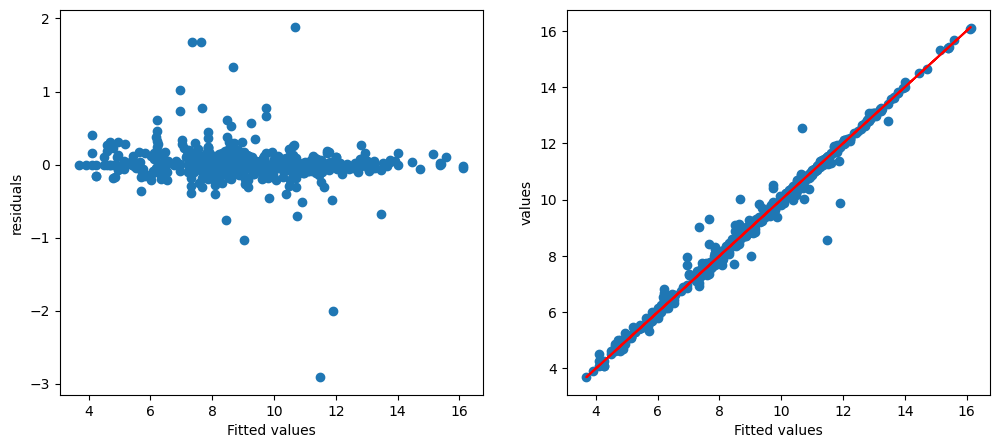

In [125]:
Start=time.time()
y_chap_cart = treeOpt.predict(Xr_test)
cart_mse=mean_squared_error(y_chap_cart,YTest)
end=time.time()
Time=end-Start
Mse_M["Cart"]=cart_mse
Time_M["Cart"]=Time
print("Time= ",Time)
print("MSE=",cart_mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap_cart,YTest-y_chap_cart)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap_cart,YTest)
plt.plot(y_chap_cart,y_chap_cart,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
treeG=DecisionTreeRegressor(max_depth=treeOpt.best_params_['max_depth'])
treeG.fit(Xr_train,YTrain)
plot_tree(treeG,feature_names=df.columns.tolist());
plt.show()

### <span style="color:blue"> **III.D Random forest**  </span>

In [ ]:
 from sklearn.ensemble import RandomForestRegressor 
import time
start_time = time.time()
# définition des paramètres
forest = RandomForestRegressor(n_estimators=500,  max_depth=None,
   min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(Xr_train,YTrain)
#Erreur Out Of Bag
print(1-rfFit.oob_score_)
end_time = time.time()
# Calculate execution time
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

In [ ]:
 # erreur de prévision sur le test
1-rfFit.score(Xr_test,YTest)

In [ ]:
# param=[{"n_estimators":list(range(1,500,50))}]
# rf= GridSearchCV(RandomForestRegressor(n_estimators=100),
#         param,cv=5,n_jobs=-1)
# rfOpt=rf.fit(Xr_train, YTrain)
# # paramètre optimal
# print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

In [ ]:
param=[{"max_features":list(range(2,20,2))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, YTrain)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

In [ ]:
# Importance décroissante des variables
importances = rfFit.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(Xr_train.shape[1]):
    print(df.columns[indices[f]], importances[indices[f]])

In [ ]:
# définition des paramètres
start=time.time()
forest = RandomForestRegressor(n_estimators=351,  max_depth=None,
   min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None,
   bootstrap=True, oob_score=True,max_features=12)
# apprentissage
rfFit = forest.fit(XTrain,YTrain)
end=time.time()
Time=end-start
Time_M["RandomForest"]=Time
#Erreur Out Of Bag
print(1-rfFit.oob_score_)



In [ ]:
 # Graphe des importances
plt.figure()
plt.title("Importance des variables")
plt.bar(range(Xr_train.shape[1]), importances[indices]);
plt.xticks(range(Xr_train.shape[1]), indices);
plt.xlim([-1, Xr_train.shape[1]]);
plt.show()

In [ ]:
y_chap_rf = forest.predict(XTest)
rf_mse=mean_squared_error(y_chap_rf,YTest)
Mse_M["RandomForest"]=rf_mse
print("MSE=",rf_mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap_rf,YTest-y_chap_rf)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap_rf,YTest)
plt.plot(y_chap_rf,y_chap_rf,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

### <span style="color:blue"> **III.E Réseaux de neurone**  </span>

In [ ]:
 from sklearn.neural_network import MLPRegressor
    

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (15,), (20,)],  
    'activation': ['relu', 'tanh', 'logistic'],           
    'alpha': [0.0001, 0.001, 0.01],                       
    'learning_rate_init': [0.001, 0.01, 0.1]              
}


nnet = MLPRegressor(max_iter=500)


grid_search = GridSearchCV(estimator=nnet, param_grid=param_grid, cv=10, n_jobs=-1)

s=time.time()
grid_search.fit(Xr_train, YTrain)




y_pred = grid_search.predict(Xr_test)
mse = mean_squared_error(YTest, y_pred)
end=time.time()
Time=end-s
Mse_M["NeuralNetwork"]=mse
Time_M["NeuralNetwork"]=Time
print("Mean Squared Error on Test Set:", mse)
print("Time= ",Time)
print("Meilleur score =", 1. - grid_search.best_score_)
print("Meilleurs paramètres =", grid_search.best_params_)

In [ ]:
print(Mse_M)
print(Time_M)

In [ ]:

sorted_Mse_M = dict(sorted(Mse_M.items(), key=lambda item: item[1]))
sorted_Time_M = dict(sorted(Time_M.items(), key=lambda item: item[1]))


print("MSE trié :", sorted_Mse_M)
print("Temps trié :", sorted_Time_M)


In [ ]:
plt.figure(figsize=(20, 10))

# Plot du MSE par méthode
plt.bar(sorted_Mse_M.keys(), sorted_Mse_M.values())
plt.title('MSE par méthode')
plt.xlabel('Méthode')
plt.ylabel('MSE')
plt.xticks(rotation=45)  
plt.show()

# Plot du temps par méthode
plt.figure(figsize=(20, 10))
plt.bar(sorted_Time_M.keys(), sorted_Time_M.values())
plt.title('Temps par méthode')
plt.xlabel('Méthode')
plt.ylabel('Temps (s)')
plt.xticks(rotation=45)  
plt.show()


### <span style="color:blue"> **IV Modélisation avec les données manquantes**  </span>

#### <span style="color:blue"> **IV.A Imputation des données manquantes**  </span>

In [ ]:
energy3=pd.read_csv('global-data-on-sustainable-energy.csv')
energy3.head()


In [ ]:

energy3.rename(columns={energy3.columns[17]: 'Density'}, inplace=True) #renommer la colonne Density pour faciliter l'accés à la variable
energy3['Density']= pd.to_numeric(energy3['Density'], errors='coerce')


In [ ]:

energy3['Year']=energy3['Year'].astype(int)
# Définir les labels pour les catégories
bins = [2000, 2004, 2008, 2012, 2016]  
labels = ['2000-2004', '2004-2008', '2008-2012', '2012-2016']

# Transformer les années en periodes
energy3['Periode'] = pd.cut(energy3['Year'], bins=bins, labels=labels)
energy3['Periode'] = energy3['Periode'].astype('category')
energy3.drop(columns=['Year'],inplace=True)
energy3.head()

energy3['Continent']= coco.convert(names=energy3['Entity'], to='continent')

energy3.drop(['Entity'],axis=1, inplace=True)

In [ ]:
# Prendre la racine carrée des colonnes spécifiques
columns_sqrt = ["Access to electricity (% of population)",
                "Access to clean fuels for cooking",
                "Renewable energy share in the total final energy consumption (%)",
                "Electricity from nuclear (TWh)","Primary energy consumption per capita (kWh/person)",
                "Electricity from renewables (TWh)",
                "Low-carbon electricity (% electricity)"]
energy3[columns_sqrt] = np.sqrt(energy3[columns_sqrt])

# Prendre le logarithme des colonnes spécifiques
columns_log = ["gdp_per_capita",
               "Density",
               "Land Area(Km2)","Value_co2_emissions_kt_by_country",]
energy3[columns_log] = np.log(energy3[columns_log])

#Nous isolons la variable à prédire, 

#energy3.drop(["Value_co2_emissions_kt_by_country"],axis=1,inplace=True)

#Nous enlecons les variables quantitatives qui ont beaucoup de NaN
energy3.drop(["Renewable-electricity-generating-capacity-per-capita","Financial flows to developing countries (US $)","Renewables (% equivalent primary energy)"],axis=1,inplace=True)
energy3.drop(['Electricity from fossil fuels (TWh)'],axis=1,inplace=True)

In [ ]:
#On retire les variables qualitatives
energyQuant3=energy3.drop(["Periode","Continent"],axis=1)

##### <span style="color:blue"> **IV.A.1 Imputation simple**  </span>

In [ ]:
from sklearn.impute import SimpleImputer

energyQuant_mean = SimpleImputer().fit_transform(energyQuant3)


In [ ]:
energyQuant_meanImp=pd.DataFrame(energyQuant_mean, columns=energyQuant3.columns)
energyQuant_meanImp.head()

##### <span style="color:blue"> **IV.A.2 Imputation avec KNN**  </span>

In [ ]:
from sklearn.impute import  KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)L
energyQuant_kNN = knn_imputer.fit_transform(energyQuant3)

In [ ]:
energyQuant_kNNImp=pd.DataFrame(energyQuant_kNN,columns=energyQuant3.columns)
energyQuant_kNNImp.head()

##### <span style="color:blue"> **IV.A.3 Imputation avec Missforest**  </span>

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
estimator_rf = ExtraTreesRegressor(n_estimators=20, random_state=0)
energyQuant_rf = IterativeImputer(estimator=estimator_rf, random_state=0, max_iter=300,tol=4e-2).fit_transform(energyQuant3)

In [ ]:
energyQuant_rfIMp=pd.DataFrame(energyQuant_rf,columns=energyQuant3.columns)
energyQuant_rfIMp.head()

In [ ]:
def set(data,dataquant):
    Value_CO2=dataquant["Value_co2_emissions_kt_by_country"]
    dataquant2=dataquant.drop(["Value_co2_emissions_kt_by_country"],axis=1,)
    dataDum1=pd.get_dummies(data[['Periode','Continent']])
    df= pd.concat([dataDum1, dataquant2], axis=1) 
    scaler = StandardScaler()   
    XTrain, XTest, YTrain, YTest = train_test_split(df,Value_CO2 , test_size=0.2, random_state=11)
    scaler.fit(XTrain)
    Xr_train = scaler.transform(XTrain)
    
    Xr_test = scaler.transform(XTest)
    return Xr_train,Xr_test,YTrain,YTest
    

#### <span style="color:blue"> **IV.B Prédiction avec les données imputées**  </span>

#### <span style="color:blue"> **IV.B.1 Avec la méthode Simple**  </span>

In [ ]:
Xr_train,Xr_test,YTrain, YTest=set(energy3,energyQuant_meanImp)

#### <span style="color:blue"> **a. Regression Linéaire**  </span>

In [ ]:
regLin = LinearRegression()
regLin.fit(Xr_train, YTrain)

# Making predictions on the testing set
y_chap = regLin.predict(Xr_test)

# Calculating mean squared error
mse = mean_squared_error(YTest, prev)
R2=r2_score(YTest,prev)

print("MSE =", mse)
print("R2 =",R2)

In [ ]:
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YTest-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YTest)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

#### <span style="color:blue"> **b. Regression Linéaire avec Lasso**  </span>

In [ ]:
param=[{"alpha":[0,0.05,0.1,0.2,0.3,50,500,1000,1500]}]
regLasso = GridSearchCV(Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, YTrain)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

In [ ]:
# Making predictions on the testing set
y_chap = regLassOpt.predict(Xr_test)

# Calculating mean squared error
mse = mean_squared_error(YTest, prev)
R2=r2_score(YTest,y_chap)

print("MSE =", mse)
print("R2 =",R2)

In [ ]:
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YTest-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YTest)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

#### <span style="color:blue"> **c. SVM**  </span>

In [ ]:
inputY=energyQuant_meanImp["Value_co2_emissions_kt_by_country"]
inputX=energyQuant_meanImp.drop(["Value_co2_emissions_kt_by_country"],axis=1)
XTr_svm, XT_svm, YTr_svm, YT_svm = train_test_split(inputX, inputY, test_size=0.2, random_state=11)
scaler.fit(XTr_svm)
Xr_train_svm = scaler.transform(XTr_svm)

Xr_test_svm = scaler.transform(XT_svm)

In [ ]:
param = {'degree': [2, 3, 4,5,6]}  # Range of C and degree values to try
svm = GridSearchCV(SVR(epsilon=0.1, kernel='poly'), param_grid=param, cv=10, n_jobs=-1)
svmOpt = svm.fit(Xr_train_svm, YTr_svm)

# Best parameters
print("Best score = %f, Best parameters = %s" % (1. - svmOpt.best_score_, svmOpt.best_params_))

In [ ]:
y_chap=svmOpt.predict(Xr_test_svm)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YT_svm-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YT_svm)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

#### <span style="color:blue"> **d. Cart**  </span>

In [ ]:
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,18))}]
tree= GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(Xr_train, YTrain)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

In [ ]:
y_chap_= treeOpt.predict(Xr_test)
mse=mean_squared_error(y_chap_,YTest)

print("MSE=",mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap_,YTest-y_chap_)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap_,YTest)
plt.plot(y_chap_,y_chap_,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

#### <span style="color:blue"> **e. Random Forest**  </span>

In [ ]:
param=[{"max_features":list(range(2,20,2))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, YTrain)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

In [ ]:
y_chap = rfOpt.predict(Xr_test)
rf_mse=mean_squared_error(y_chap,YTest)
print("MSE=",rf_mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YTest-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YTest)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

#### <span style="color:blue"> **IV.B.2 Avec la méthode KNN**  </span>

In [ ]:
Xr_train,Xr_test,YTrain, YTest=set(energy3,energyQuant_kNNImp)

##### <span style="color:blue"> **a. Regression Linéaire**  </span>

In [ ]:
regLin = LinearRegression()
regLin.fit(Xr_train, YTrain)

# Making predictions on the testing set
y_chap = regLin.predict(Xr_test)

# Calculating mean squared error
mse = mean_squared_error(YTest, prev)
R2=r2_score(YTest,prev)

print("MSE =", mse)
print("R2 =",R2)

In [ ]:
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YTest-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YTest)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

##### <span style="color:blue"> **b. Regression Linéaire avec Lasso**  </span>

In [ ]:
param=[{"alpha":[0,0.05,0.1,0.2,0.3,50,500,1000,1500]}]
regLasso = GridSearchCV(Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, YTrain)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

In [ ]:
# Making predictions on the testing set
y_chap = regLassOpt.predict(Xr_test)

# Calculating mean squared error
mse = mean_squared_error(YTest, prev)
R2=r2_score(YTest,y_chap)

print("MSE =", mse)
print("R2 =",R2)

In [ ]:
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YTest-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YTest)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

##### <span style="color:blue"> **c. SVM**  </span>

In [ ]:
# Calculate execution time
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")inputY=energyQuant_kNNImp["Value_co2_emissions_kt_by_country"]
inputX=energyQuant_kNNImp.drop(["Value_co2_emissions_kt_by_country"],axis=1)
XTr_svm, XT_svm, YTr_svm, YT_svm = train_test_split(inputX, inputY, test_size=0.2, random_state=11)
scaler.fit(XTr_svm)
Xr_train_svm = scaler.transform(XTr_svm)

Xr_test_svm = scaler.transform(XT_svm)

In [ ]:
param = {'degree': [2, 3, 4,5,6]}  # Range of C and degree values to try
svm = GridSearchCV(SVR(epsilon=0.1, kernel='poly'), param_grid=param, cv=10, n_jobs=-1)
svmOpt = svm.fit(Xr_train_svm, YTr_svm)

# Best parameters
print("Best score = %f, Best parameters = %s" % (1. - svmOpt.best_score_, svmOpt.best_params_))

y_chap=svmOpt.predict(Xr_test_svm)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YT_svm-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YT_svm)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

##### <span style="color:blue"> **d. CART**  </span>

In [ ]:
param=[{"max_depth":list(range(2,18))}]
tree= GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(Xr_train, YTrain)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

In [ ]:
y_chap_= treeOpt.predict(Xr_test)
mse=mean_squared_error(y_chap_,YTest)

print("MSE=",mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap_,YTest-y_chap_)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap_,YTest)
plt.plot(y_chap_,y_chap_,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

##### <span style="color:blue"> **e. Random Forest**  </span>

In [ ]:
param=[{"max_features":list(range(2,20,2))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, YTrain)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

In [ ]:
y_chap = rfOpt.predict(Xr_test)
rf_mse=mean_squared_error(y_chap,YTest)
print("MSE=",rf_mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YTest-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YTest)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

#### <span style="color:blue"> **IV.B.3 Avec la méthode MissForest**  </span>

In [ ]:
Xr_train,Xr_test,YTrain, YTest=set(energy3,energyQuant_rfIMp)

##### <span style="color:blue"> **a. Regression Linéaire**  </span>

In [ ]:
regLin = LinearRegression()
regLin.fit(Xr_train, YTrain)

# Making predictions on the testing set
y_chap = regLin.predict(Xr_test)

# Calculating mean squared error
mse = mean_squared_error(YTest, prev)
R2=r2_score(YTest,prev)

print("MSE =", mse)
print("R2 =",R2)

In [ ]:
y_chap = regLin.predict(Xr_test)
mse=mean_squared_error(y_chap,YTest)
print("MSE=",rf_mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YTest-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YTest)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

##### <span style="color:blue"> **a. Regression Linéaire avec Lasso**  </span>

In [ ]:
param=[{"alpha":[0,0.05,0.1,0.2,0.3,50,500,1000,1500]}]
regLasso = GridSearchCV(Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, YTrain)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

In [ ]:
# Making predictions on the testing set
y_chap = regLassOpt.predict(Xr_test)

# Calculating mean squared error
mse = mean_squared_error(YTest, prev)
R2=r2_score(YTest,y_chap)

print("MSE =", mse)
print("R2 =",R2)

In [ ]:
y_chap = regLassOpt.predict(Xr_test)
mse=mean_squared_error(y_chap,YTest)
print("MSE=",rf_mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YTest-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YTest)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

##### <span style="color:blue"> **c. SVM**  </span>

In [ ]:
inputY=energyQuant_rfIMp["Value_co2_emissions_kt_by_country"]
inputX=energyQuant_rfIMp.drop(["Value_co2_emissions_kt_by_country"],axis=1)
XTr_svm, XT_svm, YTr_svm, YT_svm = train_test_split(inputX, inputY, test_size=0.2, random_state=11)
scaler.fit(XTr_svm)
Xr_train_svm = scaler.transform(XTr_svm)

Xr_test_svm = scaler.transform(XT_svm)

In [ ]:
param = {'degree': [2, 3, 4,5,6]}  # Range of C and degree values to try
svm = GridSearchCV(SVR(epsilon=0.1, kernel='poly'), param_grid=param, cv=10, n_jobs=-1)
svmOpt = svm.fit(Xr_train_svm, YTr_svm)

# Best parameters
print("Best score = %f, Best parameters = %s" % (1. - svmOpt.best_score_, svmOpt.best_params_))

In [ ]:
y_chap=svmOpt.predict(Xr_test_svm)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YT_svm-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap,YT_svm)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

##### <span style="color:blue"> **d. CART**  </span>

In [ ]:
param=[{"max_depth":list(range(2,18))}]
tree= GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(Xr_train, YTrain)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

In [ ]:
y_chap_= treeOpt.predict(Xr_test)
mse=mean_squared_error(y_chap_,YTest)

print("MSE=",mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap_,YTest-y_chap_)
plt.xlabel('Fitted values')
plt.ylabel('residuals')

plt.subplot(1,2,2)
plt.scatter(y_chap_,YTest)
plt.plot(y_chap_,y_chap_,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

##### <span style="color:blue"> **e. Random Forest**  </span>

In [32]:
param=[{"max_features":list(range(2,20,2))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, YTrain)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

NameError: name 'GridSearchCV' is not defined

In [33]:
y_chap = rfOpt.predict(Xr_test)
rf_mse=mean_squared_error(y_chap,YTest)
print("MSE=",rf_mse)
plt.subplots_adjust(wspace=1.5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_chap,YTest-y_chap)
plt.xlabel('Fitted values')
plt.ylabel('residuals')


plt.subplot(1,2,2)
plt.scatter(y_chap,YTest)
plt.plot(y_chap,y_chap,'r')
plt.xlabel('Fitted values')
plt.ylabel('values')
plt.show()

NameError: name 'rfOpt' is not defined